In [105]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [8]:
import os
import zipfile

def zip_directory(folder_path, zip_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # os.walk to list all directories and files
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create a full path to the file
                full_path = os.path.join(root, file)
                # Write the file to the zip file, adjust the path relative to the folder being zipped
                zipf.write(full_path, os.path.relpath(full_path, folder_path))

# Current working directory
current_dir = 'data'

# Name of the zip file to create
zip_filename = 'data.zip'

# Call the function to zip the directory
zip_directory(current_dir, zip_filename)

print(f"Zipped the current directory into '{zip_filename}'")


KeyboardInterrupt: 

In [6]:
import os

def get_folder_size(folder):
    total_size = 0
    # Use os.walk to iterate through all subdirectories and files
    for root, dirs, files in os.walk(folder):
        for file in files:
            # Join the path to get the full file path
            filepath = os.path.join(root, file)
            # Use os.path.getsize to get the file size and add it to the total
            if os.path.exists(filepath):  # Checks if file still exists
                total_size += os.path.getsize(filepath)
    return total_size

# Specify the path to your folder
folder_path = 'model_shenzhen'

# Calculate the folder size
folder_size = get_folder_size(folder_path)

# Print the result in bytes
print(f"The total size of the folder '{folder_path}' is {folder_size} bytes.")

# Optionally, you can print the size in a more readable format like KB, MB, or GB
def size_format(size):
    # Define the suffixes for size
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    suffix_index = 0
    while size >= 1024 and suffix_index < len(suffixes) - 1:
        suffix_index += 1  # Increment to get to the next unit of measurement
        size /= 1024.0     # Divide size by 1024 to convert to the next unit
    return f"{size:.2f} {suffixes[suffix_index]}"

# Print the formatted size
formatted_size = size_format(folder_size)
print(f"Formatted size: {formatted_size}")


The total size of the folder 'model_shenzhen' is 467842368 bytes.
Formatted size: 446.17 MB


In [9]:
import shutil
import os

# Specify the directory to be deleted
directory_path = 'data'

# Check if the directory exists
if os.path.exists(directory_path):
    # Forcefully remove the directory and all its contents
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' has been deleted.")
else:
    print(f"Directory '{directory_path}' does not exist.")


Directory 'data' has been deleted.


In [106]:
import torch

if torch.cuda.is_available():
    print("GPU is available for computation.")
    print("CUDA device name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available for computation.
CUDA device name: NVIDIA A100 80GB PCIe MIG 2g.20gb


In [107]:
import os
print(os.getcwd())

/home/elicer


In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from sklearn.metrics import roc_auc_score
import copy

In [2]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class MedicalImageDataset(Dataset):
    def __init__(self, img_dir, augmentation=None, seed=42):
        self.img_dir = img_dir
        self.augmentation = augmentation
        torch.manual_seed(seed)
        
        self.img_names = [
            os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)
            if ".ipynb_checkpoints" not in img_name
        ]
        
        # Base transform (Grayscale, Resize, ToTensor, Normalize)
        self.base_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
        ])
        
        # Additional transforms
        self.crop_transform = transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3./4., 4./3.))
        self.flip_transform = transforms.RandomHorizontalFlip()

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_names[idx])
        image = image.convert("RGB")
        label = int(os.path.basename(self.img_names[idx])[-5])  # Assuming format: 'XXX_0.png' or 'XXX_1.png'
        
        if self.augmentation == 'crop':
            image = self.crop_transform(image)
        elif self.augmentation == 'flip':
            image = self.flip_transform(image)
        
        # Apply base transformations after specific augmentation
        image = self.base_transform(image)
            
        return image, label


In [3]:
# If Image is RGB
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Resize((224, 224)), 
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
# ])
# If Image is Grayscale
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), 
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5]), 
# ])

In [4]:
from PIL import Image, ImageFile

# Enable loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
img_dir = './data/Montgomery_img/' # Update this path
og_dataset = MedicalImageDataset(img_dir=img_dir,augmentation=None)

flip_dataset = MedicalImageDataset(img_dir=img_dir,augmentation='flip')
flip_dataset = og_dataset + flip_dataset

crop_dataset = MedicalImageDataset(img_dir=img_dir,augmentation='crop')
crop_dataset = og_dataset + crop_dataset

all_dataset = og_dataset + flip_dataset + crop_dataset


## Load Data

In [6]:
from torch.utils.data import random_split

def split_data(dataset):
    # Calculate the sizes for each dataset
    total_size = len(dataset)
    test_size = int(0.2 * total_size)  # 20% for testing
    train_val_size = total_size - test_size  # Remaining 80% for training + validation
    train_size = int(0.8 * train_val_size)  # Of the 80%, further reserve 80% for training
    val_size = train_val_size - train_size  # And the remaining 20% of the 80% for validation
    
    # Perform the splits
    train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    return train_dataset, val_dataset, test_dataset
    
def print_data_length(train, val, test, data_label):
    print(f"{data_label} - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

In [7]:
og_train, og_val, og_test = split_data(og_dataset)
flip_train, flip_val, flip_test = split_data(flip_dataset)
crop_train, crop_val, crop_test = split_data(crop_dataset)
all_train, all_val, all_test = split_data(all_dataset)

print_data_length(og_train, og_val, og_test, "Original")
print_data_length(flip_train, flip_val, flip_test, "Flip")
print_data_length(crop_train, crop_val, crop_test, "Crop")
print_data_length(all_train, all_val, all_test, "All")

Original - Train: 88, Val: 23, Test: 27
Flip - Train: 176, Val: 45, Test: 55
Crop - Train: 176, Val: 45, Test: 55
All - Train: 441, Val: 111, Test: 138


In [8]:
def print_data_lengths_one_line(train, val, test, data_label):
    print(f"{data_label} - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

def create_dataloader(train_dataset, val_dataset, test_dataset):
    # Now, create DataLoaders for each of these sets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [9]:
og_train_loader, og_val_loader, og_test_loader = create_dataloader(og_train, og_val, og_test)
flip_train_loader, flip_val_loader, flip_test_loader = create_dataloader(flip_train, flip_val, flip_test)
crop_train_loader, crop_val_loader, crop_test_loader = create_dataloader(crop_train, crop_val, crop_test)
all_train_loader, all_val_loader, all_test_loader = create_dataloader(all_train, all_val, all_test)

In [10]:
# Function to convert a tensor to a numpy array
def imshow(img, label):
    img = img.numpy().transpose((1, 2, 0)) # Convert tensor image to numpy and change dimensions to HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # Unnormalize
    img = np.clip(img, 0, 1) # Clip to make sure we're within valid range
    plt.imshow(img)
    plt.title(f'Label: {"Normal" if label == 0 else "Diseased"}')
    plt.show()

In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img, label):
#     img = img.numpy().squeeze()  # Remove the channel dimension for 1-channel image
#     mean = 0.5
#     std = 0.5
#     img = std * img + mean  # Unnormalize
#     img = np.clip(img, 0, 1)  # Ensure the values are within [0, 1]
#     plt.imshow(img, cmap='gray')  # Specify the color map for grayscale
#     plt.title(f'Label: {"Normal" if label == 0 else "Diseased"}')
#     plt.show()

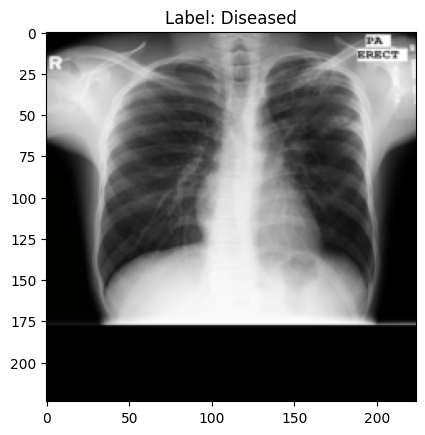

In [12]:
# Get a batch of training data
images, labels = next(iter(og_train_loader))

# # # Display the first image in the batch
imshow(images[0], labels[0])

In [13]:
# imshow(images[-1], labels[-1])

## Model Train (ResNet or GoogleNet)

In [14]:
import copy
import numpy as np

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())  
    best_loss = float('inf')  
    train_losses = []  
    val_losses = []  

    for epoch in range(epochs):  
        model.train()  
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if not torch.is_tensor(outputs):
                outputs = outputs.logits
            else:
                outputs = outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)  
        # print(f"Epoch {epoch+1}, Loss: {avg_train_loss}")
        
        # Validation 
        model.eval()  
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if not torch.is_tensor(outputs):
                    outputs = outputs.logits
                else:
                    outputs = outputs
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  
        # print(f"Epoch {epoch+1}, Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Update best model if current epoch's validation loss is the best
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_loss = np.round(best_loss, 4)
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"Saving best model at epoch {epoch+1} with validation loss: {best_loss}")

    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights='DEFAULT')
model.to(device)  
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
trained_model, train_losses, val_losses = train_model(model, criterion, optimizer, og_train_loader, og_val_loader, device, epochs=1)

Saving best model at epoch 1 with validation loss: 2.6296


Saving best model at epoch 1 with validation loss: 1.9483
Saving best model at epoch 2 with validation loss: 1.2079
Saving best model at epoch 3 with validation loss: 0.4713
Saving best model at epoch 6 with validation loss: 0.4328
Model ResNet trained on Original saved successfully.
Saving best model at epoch 1 with validation loss: 0.565
Saving best model at epoch 5 with validation loss: 0.5065
Saving best model at epoch 7 with validation loss: 0.4727
Saving best model at epoch 9 with validation loss: 0.4714
Model ResNet trained on Flip saved successfully.
Saving best model at epoch 1 with validation loss: 0.8907
Saving best model at epoch 2 with validation loss: 0.524
Saving best model at epoch 11 with validation loss: 0.515
Saving best model at epoch 14 with validation loss: 0.4737
Saving best model at epoch 18 with validation loss: 0.4542
Model ResNet trained on Crop saved successfully.
Saving best model at epoch 1 with validation loss: 0.3396
Saving best model at epoch 4 with val

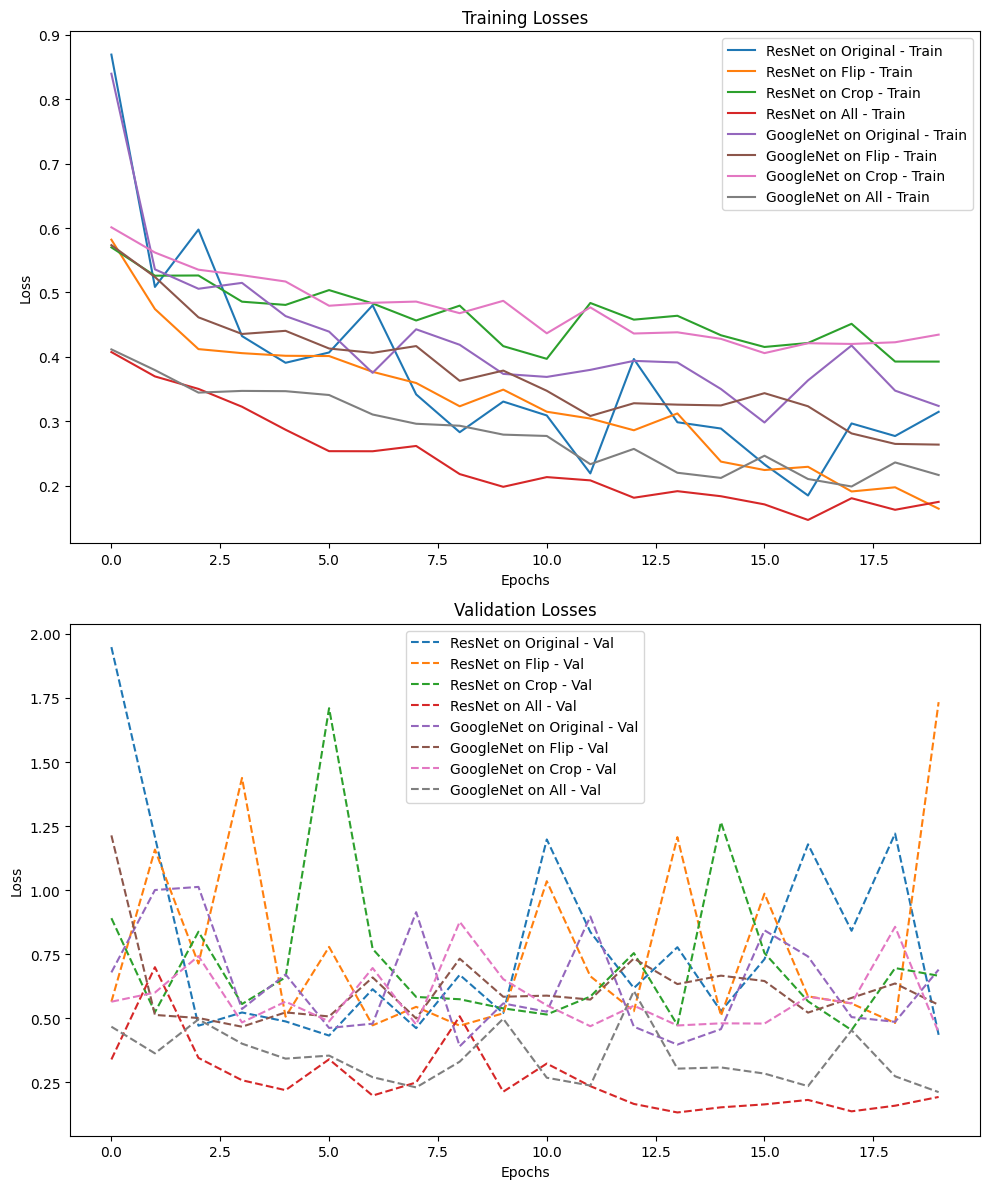

In [122]:
import torch
import matplotlib.pyplot as plt

# Define your models with names
models_list = {
    'ResNet': models.resnet50(weights=None),
    'GoogleNet': models.googlenet()
}

# Define your dataloaders with names
data_loaders = {
    'Original': (og_train_loader, og_val_loader),
    'Flip': (flip_train_loader, flip_val_loader),
    'Crop': (crop_train_loader, crop_val_loader),
    'All': (all_train_loader, all_train_loader)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_model is the training function you provided earlier

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the figure size as needed

for model_name, model in models_list.items():
    if model_name == 'GoogleNet':
        model = models.googlenet()
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == 'ResNet':
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 2)
    else:
        raise ValueError("Unknown model name")
    
    for dataset_name, (train_loader, val_loader) in data_loaders.items():
        model.to(device)  # Move model to the appropriate device
        criterion = torch.nn.CrossEntropyLoss()  # Define the loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer
        
        # Train the model
        trained_model, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=20)
        
        # Plotting
        ax1.plot(train_losses, label=f'{model_name} on {dataset_name} - Train')
        ax2.plot(val_losses, label=f'{model_name} on {dataset_name} - Val', linestyle='--')

        # Save Model
        torch.save(trained_model.state_dict(), f'Shenzhen_{model_name}_{dataset_name}_model.pth')
        print(f"Model {model_name} trained on {dataset_name} saved successfully.")

# Set titles and labels for the first subplot
ax1.set_title('Training Losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Set titles and labels for the second subplot
ax2.set_title('Validation Losses')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Model Test

In [17]:
import numpy as np
import torch

def test_model(model, test_loader, device):
    model.eval()  
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.sigmoid(outputs)
            
            predictions.append(probabilities.cpu())
            true_labels.append(labels.cpu())

    predictions_tensor = torch.cat(predictions, dim=0)
    true_labels_tensor = torch.cat(true_labels, dim=0)

    predictions_np = predictions_tensor.numpy()
    true_labels_np = true_labels_tensor.numpy()

    #roc_auc_score
    auc_roc = roc_auc_score(true_labels_np, predictions_np[:,1])
    return auc_roc

In [19]:
auc_roc_score = test_model(model, og_test_loader, device)
auc_roc_score

0.5852272727272727

In [124]:
import pandas as pd

# Define your models and test loaders with names
models_list = {
    'ResNet': models.resnet50(weights=None),
    'GoogleNet': models.googlenet()
}

# Update the models here with pretrained settings if necessary, e.g., modify final layers

test_loaders = {
    'Original': og_test_loader,
    'Flip': flip_test_loader,
    'Crop': crop_test_loader,
    'All': all_test_loader
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List to store results for DataFrame
results = []

for model_name, model in models_list.items():
    # Load the saved model weights
    # Assume the model was trained and saved with the name format: "{model_name}_{dataset_name}_model.pth"
    # For testing, choose which dataset's trained model you want to load, e.g., "Dataset1"

    
    for test_name, test_loader in test_loaders.items():
        model_path = f'Shenzhen_{model_name}_{test_name}_model.pth'
        model.fc = nn.Linear(model.fc.in_features, 2)
        model.load_state_dict(torch.load(model_path))
        model.to(device)  # Move model to the device
        
        # Test the model
        auc_roc_score = test_model(model, test_loader, device)
        # Append results in list
        results.append({'Model': model_name, 'Test Data': test_name, 'AUC ROC Score': auc_roc_score})

# Create DataFrame from results list
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

       Model Test Data  AUC ROC Score
0     ResNet  Original       0.838613
1     ResNet      Flip       0.917293
2     ResNet      Crop       0.851607
3     ResNet       All       0.974971
4  GoogleNet  Original       0.832874
5  GoogleNet      Flip       0.879470
6  GoogleNet      Crop       0.830080
7  GoogleNet       All       0.981130


In [125]:
results_df

,Model,Test Data,AUC ROC Score
0,ResNet,Original,0.838613
1,ResNet,Flip,0.917293
2,ResNet,Crop,0.851607
3,ResNet,All,0.974971
4,GoogleNet,Original,0.832874
5,GoogleNet,Flip,0.879470
6,GoogleNet,Crop,0.830080
7,GoogleNet,All,0.981130
